In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Questions

1. The customer who bought the most items overall in her lifetime
2. For each item, the customer who bought that product the most
3. Cluster items based on user co-purchase history.

**Merge table and clean data**

In [2]:
#load data
item = pd.read_csv("item_to_id.csv")
user = pd.read_csv("purchase_history.csv")
cluster_user = user.copy()
print("unique items: ", item.shape[0])
print("total number of transactions: ", user.shape[0])
print("unique users: ", len(user['user_id'].unique()))

unique items:  48
total number of transactions:  39474
unique users:  24885


In [3]:
#clean user table by removing ',' in id column and separate items by id
user = pd.DataFrame(user.id.str.split(',').tolist(), index = user.user_id).stack()
user = user.reset_index()[[0, 'user_id']]
user.columns = ['id', 'user_id']
user['id'] = user['id'].astype('int')
item['Item_id'] =item['Item_id'].astype('int')

In [4]:
data = pd.merge(user, item, left_on = 'id', right_on = 'Item_id')
data.drop('id', axis = 1, inplace = True)
data.head()

,user_id,Item_name,Item_id
0,222087,dishwashing,27
1,404134,dishwashing,27
2,987613,dishwashing,27
3,60201,dishwashing,27
4,1166671,dishwashing,27


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319995 entries, 0 to 319994
Data columns (total 3 columns):
user_id      319995 non-null int64
Item_name    319995 non-null object
Item_id      319995 non-null int32
dtypes: int32(1), int64(1), object(1)
memory usage: 8.5+ MB


In [6]:
#check nulls
data.isnull().sum()

user_id      0
Item_name    0
Item_id      0
dtype: int64

Data explorations
1. Most users have bought between 1-20 products
2. Item bought most by users is *Lettuce*, and item bought by least amount of users is *flour*

Text(0.5,1,'number of products users purchase')

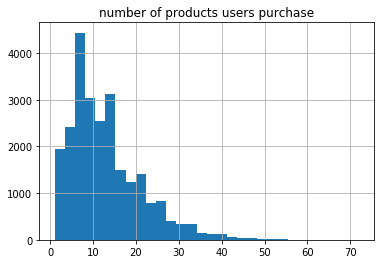

In [7]:
user = data.groupby('user_id')['Item_name'].count()
user.hist(bins = 30)
plt.title("number of products users purchase")

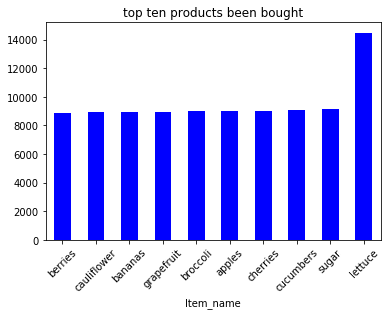

In [8]:
product = data.groupby('Item_name')['user_id'].count().sort_values()
product[-10:].plot(kind='bar',color = 'b',title ='top ten products been bought', rot = 45)

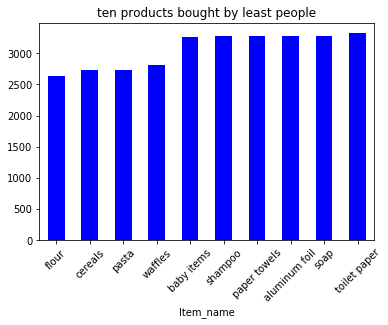

In [9]:
product[:10].plot(kind = 'bar', color = 'b', title = 'ten products bought by least people', rot=45)

**Q1. user who bought the most items in her lifetime is 269335**

In [10]:
most_product_id = user[user.values == max(user)]
print("The user who bought most products is {}, and has bought {} items".format(most_product_id.index[0], most_product_id.values[0]))

The user who bought most products is 269335, and has bought 72 items


**Q2. For each item, the customer who bought that product the most**

In [11]:
item_most = data.groupby(['Item_name','user_id'])['user_id'].count()
item_most_id = item_most.unstack().idxmax(axis = 1)
item_dict = {"user":[], "item":[], "number":[]}
for prod in item_most_id.index:
    item_dict['user'].append(item_most_id[prod])
    item_dict['item'].append(prod)
    item_dict['number'].append(item_most[prod][item_most_id[prod]])
new_df = pd.DataFrame(item_dict)
new_df

,item,number,user
0,aluminum foil,3,143741
1,apples,4,109578
2,baby items,3,5289
3,bagels,4,653800
4,bananas,4,1218645
5,beef,4,366155
6,berries,4,38872
7,broccoli,4,31625
8,butter,3,151926
9,canned vegetables,4,204624


**Q3. cluster based on co-purchase history**

1. Hierarchical clustering using item-item similarity matrix
2. kmeans clustering using user-item matrix. reference: https://github.com/JifuZhao/DS-Take-Home/blob/master/09.%20Clustering%20Grocery%20Items.ipynb

**1. Hierarchical clustering**

In [12]:
#step 1. create user-item matrix
user_item = data.groupby(['user_id','Item_id'])['Item_id'].count().unstack(fill_value = 0)
user_item.head()

Item_id,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [13]:
#step 2. create item-item matrix
from sklearn.preprocessing import normalize
user_item_norm = normalize(user_item, axis = 0)
item_item = user_item_norm.T.dot(user_item_norm)
item_item_df = pd.DataFrame(item_item)
item_item_df.head()

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
1,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
2,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
3,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
4,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


In [14]:
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

#try from 2 to 24 clusters
clusters = range(2,25)
silhouettes_width = []

for cluster in clusters:
    hierar = AgglomerativeClustering(n_clusters = cluster, affinity= 'euclidean', linkage = 'complete')
    label = hierar.fit_predict(item_item_df)
    silhouettes_width.append(silhouette_score(item_item_df, label))

Based on below plot, it seems that 20 clusters is the best choice

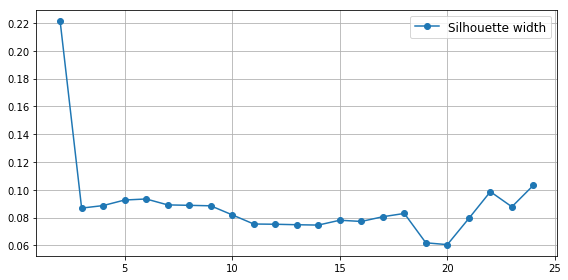

In [15]:
#visualization
fig, ax = plt.subplots(figsize = (8,4))
ax.grid(True)
ax.plot(clusters, silhouettes_width, 'o-', label = 'Silhouette width')
plt.legend(fontsize = 12)
plt.tight_layout()

Some of the clusters look weird(e.g. Cluster 4, food and nonfood mixed), but some makes sense(e.g. First 2 items of cluster 6)

In [16]:
#take a look at the clustered items
hier = AgglomerativeClustering(n_clusters=20, affinity = 'euclidean',linkage ='complete')
label = hier.fit_predict(item_item_df)
label_df = pd.DataFrame({"Item_id":range(48), "Cluster": label})
out_df = pd.merge(item, label_df, on = 'Item_id', how = 'inner').drop('Item_id', axis=1)
for i in range(20):
    print("Cluster {}, Items: {}".format(i, out_df[out_df['Cluster'] == i].Item_name.values))

Cluster 0, Items: ['juice' 'sandwich loaves' 'dinner rolls' 'milk' 'butter' 'pasta'
 'waffles' 'frozen vegetables' 'ice cream' 'bananas' 'cauliflower'
 'cucumbers' 'paper towels' 'toilet paper' 'shampoo' 'shaving cream']
Cluster 1, Items: ['coffee' 'soda' 'ketchup' 'sugar' 'broccoli']
Cluster 2, Items: ['bagels' 'pork' 'grapefruit' 'aluminum foil' 'sandwich bags']
Cluster 3, Items: ['spaghetti sauce' 'beef']
Cluster 4, Items: ['cheeses' 'soap']
Cluster 5, Items: ['tortillas']
Cluster 6, Items: ['berries' 'cherries' 'dishwashing\xa0']
Cluster 7, Items: ['flour']
Cluster 8, Items: ['apples']
Cluster 9, Items: ['hand soap']
Cluster 10, Items: ['eggs']
Cluster 11, Items: ['pet items']
Cluster 12, Items: ['poultry']
Cluster 13, Items: ['carrots']
Cluster 14, Items: ['tea']
Cluster 15, Items: ['cereals']
Cluster 16, Items: ['canned vegetables']
Cluster 17, Items: ['baby items']
Cluster 18, Items: ['lettuce']
Cluster 19, Items: ['laundry detergent']


**2. Kmeans clustering**

In [17]:
feature = user_item.T
feature.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
Item_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
kmeans_clusters = range(2,25)
kmeans_silwidth = list()
kmeans_l2 = list()

for n in kmeans_clusters:
    kmeans = KMeans(n_clusters=n, init = 'k-means++', random_state = 42)
    kmeans = kmeans.fit(feature)
    kmean_l = kmeans.predict(feature)
    
    kmeans_silwidth.append(silhouette_score(feature, kmean_l))
    kmeans_l2.append(kmeans.inertia_)

Based on below plot, n = 17 is probably the best choice

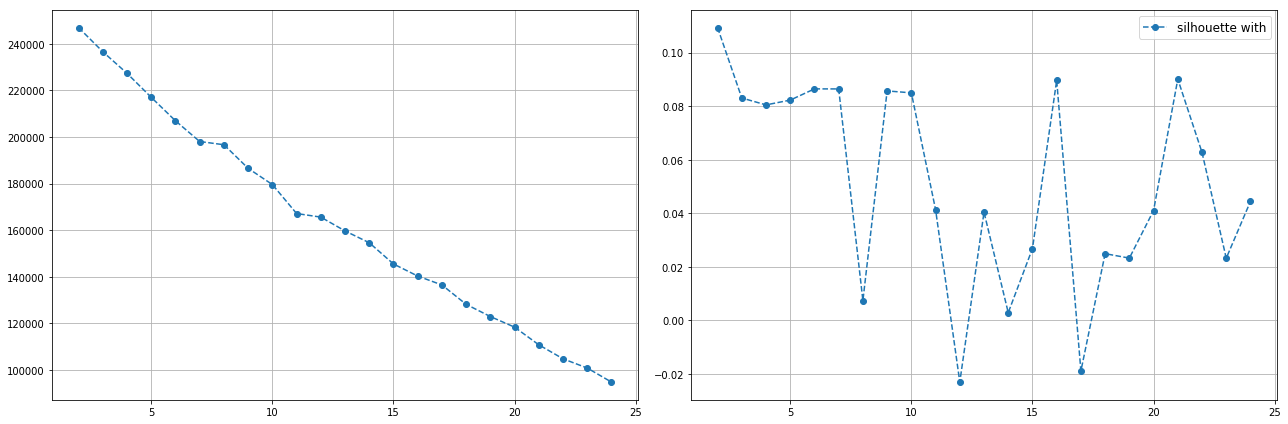

In [19]:
#visualization
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(18,6))
ax[0].plot(kmeans_clusters, kmeans_l2, 'o--', label = 'Sum of Squared distance')
ax[0].grid(True)
ax[1].plot(kmeans_clusters, kmeans_silwidth, 'o--', label = 'silhouette with')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()

In [20]:
#PCA visualization. reference: https://github.com/JifuZhao/DS-Take-Home/blob/master/09.%20Clustering%20Grocery%20Items.ipynb

kmeans = KMeans(n_clusters=17, init = 'k-means++', random_state = 42)
kmeans = kmeans.fit(feature)
km_l = kmeans.predict(feature)

pca = PCA(n_components=2, random_state = 42)
pca = pca.fit(feature)
pca_feature = pca.transform(feature)

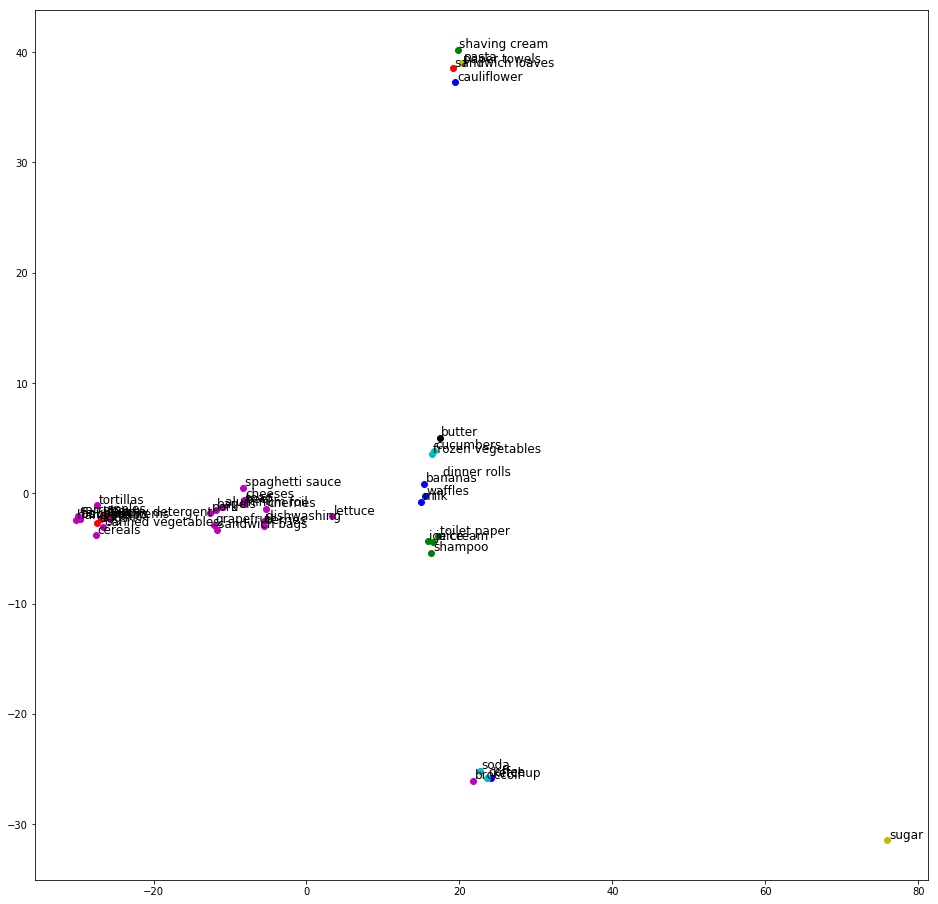

In [21]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize = (16,16))
for n in range(1, pca_feature.shape[0]):
    x = pca_feature[n][0]
    y = pca_feature[n][1]
    ax.plot(x, y, 'o', color = colors[km_l[n] % 8])
    name = item[item.Item_id == n]['Item_name'].values[0]
    ax.annotate(xy = (x+0.2, y+0.2), s= name, fontsize = 12)

Again, some clusters look weird, while some look normal(e.g. Cluster 4)

In [22]:
#take a look at the clustered items
kmeans_df = pd.DataFrame({"Item_id":range(48), "Cluster": km_l})
out_k_df = pd.merge(item, kmeans_df, on = 'Item_id', how = 'inner').drop('Item_id', axis=1)
for i in range(17):
    print("Cluster {}, Items: {}".format(i, out_k_df[out_k_df['Cluster'] == i].Item_name.values))

Cluster 0, Items: ['milk' 'waffles' 'bananas']
Cluster 1, Items: ['juice' 'ice cream' 'toilet paper' 'shampoo']
Cluster 2, Items: ['tea' 'eggs' 'poultry' 'apples']
Cluster 3, Items: ['coffee' 'soda']
Cluster 4, Items: ['tortillas' 'bagels' 'canned vegetables' 'spaghetti sauce' 'cheeses'
 'cereals' 'flour' 'pork' 'berries' 'cherries' 'grapefruit' 'broccoli'
 'carrots' 'lettuce' 'laundry detergent' 'dishwashing\xa0' 'aluminum foil'
 'sandwich bags' 'soap' 'hand soap' 'baby items' 'pet items']
Cluster 5, Items: ['sugar']
Cluster 6, Items: ['butter']
Cluster 7, Items: ['dinner rolls']
Cluster 8, Items: ['ketchup']
Cluster 9, Items: ['shaving cream']
Cluster 10, Items: ['sandwich loaves']
Cluster 11, Items: ['frozen vegetables' 'cucumbers']
Cluster 12, Items: []
Cluster 13, Items: ['pasta']
Cluster 14, Items: ['beef']
Cluster 15, Items: ['paper towels']
Cluster 16, Items: ['cauliflower']
